# Spaceship Titanic: Simple PyTorch MLP

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score
)
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# reproducibility
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

def mps_ok():
    return hasattr(torch.backends, "mps") and torch.backends.mps.is_built() and torch.backends.mps.is_available()

def auto_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    if mps_ok():
        return torch.device("mps")
    return torch.device("cpu")

device = auto_device()
print("Using device:", device)


Using device: mps


# Load Preprocessed Data

In [2]:

POSSIBLE_DIRS = [
    "from_kaggle/cleaned_data",
    "/kaggle/working",
    "/kaggle/input",
]

def find_clean_paths():
    for d in POSSIBLE_DIRS:
        train_candidate = os.path.join(d, "train_clean.csv")
        test_candidate = os.path.join(d, "test_clean.csv")
        if os.path.exists(train_candidate) and os.path.exists(test_candidate):
            return train_candidate, test_candidate
    raise FileNotFoundError("Could not find train_clean.csv and test_clean.csv in known locations.")

train_clean_path, test_clean_path = find_clean_paths()
print("Train clean path:", train_clean_path)
print("Test clean  path:", test_clean_path)

train_df = pd.read_csv(train_clean_path)
test_df = pd.read_csv(test_clean_path)

print("Train_clean shape:", train_df.shape)
print("Test_clean shape :", test_df.shape)
train_df.head()


Train clean path: from_kaggle/cleaned_data/train_clean.csv
Test clean  path: from_kaggle/cleaned_data/test_clean.csv
Train_clean shape: (8693, 50041)
Test_clean shape : (4277, 50040)


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,PassengerNumber,CabinNum,TotalSpend,...,Surname_Wooterston,Surname_Workmans,Surname_Workmanson,Surname_Wrempeedly,Surname_Wriggins,Surname_Wynneyerson,Surname_Yanton,Surname_Yatters,Surname_Yorkland,Surname_Youngrayes
0,0.720932,-0.340290,-0.281822,-0.292365,-0.269707,-0.257100,0.0,-0.490655,-1.181321,-0.510541,...,0,0,0,0,0,0,0,0,0,0
1,-0.332557,-0.170439,-0.276082,-0.249566,0.221040,-0.219449,1.0,-0.490655,-1.181321,-0.248363,...,0,0,0,0,0,0,0,0,0,0
2,2.055350,-0.273285,1.998823,-0.292365,5.732776,-0.215170,0.0,-0.490655,-1.181321,3.188082,...,0,0,0,0,0,0,0,0,0,0
3,0.299536,-0.340290,0.536429,0.342766,2.706059,-0.091947,0.0,0.468615,-1.181321,1.333249,...,0,0,0,0,0,0,0,0,0,0
4,-0.894417,0.131863,-0.237179,-0.033861,0.235342,-0.255389,1.0,-0.490655,-1.179351,-0.121906,...,0,0,0,0,0,0,0,0,0,0


# Prepare Features and Target

In [3]:
target_col = "Transported"

# make sure target is 0/1 numeric
if train_df[target_col].dtype == bool:
    train_df[target_col] = train_df[target_col].astype(int)
elif train_df[target_col].dtype == object:
    # map common string representations if needed
    mapping = {"True": 1, "False": 0, "true": 1, "false": 0}
    train_df[target_col] = train_df[target_col].map(mapping).astype(int)
else:
    train_df[target_col] = train_df[target_col].astype(int)

feature_cols = [c for c in train_df.columns if c != target_col]
print("Number of features:", len(feature_cols))

X = train_df[feature_cols].values.astype(np.float32)
y = train_df[target_col].values.astype(np.float32)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_val.shape


Number of features: 50040


((6954, 50040), (1739, 50040))

# Dataset and DataLoaders

In [4]:
class TitanicDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.from_numpy(X).float()
        self.y = None if y is None else torch.from_numpy(y).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        if self.y is None:
            return x
        return x, self.y[idx]

batch_size = 256

train_ds = TitanicDataset(X_train, y_train)
val_ds   = TitanicDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)


# Define simple MLP

In [5]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=(128, 64), dropout=0.3):
        super().__init__()
        layers = []
        dims = [input_dim] + list(hidden_dims)

        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))

        self.feature_extractor = nn.Sequential(*layers)
        self.classifier = nn.Linear(dims[-1], 1)  # binary logit

    def forward_features(self, x):
        return self.feature_extractor(x)

    def forward(self, x):
        feats = self.forward_features(x)
        logits = self.classifier(feats)
        return logits, feats

input_dim = X_train.shape[1]
model = SimpleMLP(input_dim=input_dim, hidden_dims=(128, 64), dropout=0.3).to(device)
model


SimpleMLP(
  (feature_extractor): Sequential(
    (0): Linear(in_features=50040, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
  )
  (classifier): Linear(in_features=64, out_features=1, bias=True)
)

# Training and Evaluation Utilities

In [6]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    n_samples = 0

    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).view(-1, 1)

        optimizer.zero_grad()
        logits, _ = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        batch_size = X_batch.size(0)
        running_loss += loss.item() * batch_size
        n_samples += batch_size

    return running_loss / max(n_samples, 1)


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    n_samples = 0
    all_logits = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).view(-1, 1)

            logits, _ = model(X_batch)
            loss = criterion(logits, y_batch)

            batch_size = X_batch.size(0)
            running_loss += loss.item() * batch_size
            n_samples += batch_size

            all_logits.append(logits.cpu().numpy())
            all_targets.append(y_batch.cpu().numpy())

    avg_loss = running_loss / max(n_samples, 1)
    all_logits = np.vstack(all_logits).reshape(-1)
    all_targets = np.vstack(all_targets).reshape(-1)

    return avg_loss, all_logits, all_targets


# Train the Model

In [7]:
lr = 1e-3
n_epochs = 40

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_losses = []
val_losses = []

for epoch in range(1, n_epochs + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_logits, val_targets = evaluate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d}/{n_epochs} | "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


Epoch 01/40 | Train Loss: 0.6266 | Val Loss: 0.5149
Epoch 05/40 | Train Loss: 0.0271 | Val Loss: 0.5755
Epoch 10/40 | Train Loss: 0.0016 | Val Loss: 0.7044
Epoch 15/40 | Train Loss: 0.0005 | Val Loss: 0.7885
Epoch 20/40 | Train Loss: 0.0003 | Val Loss: 0.8400
Epoch 25/40 | Train Loss: 0.0002 | Val Loss: 0.8646
Epoch 30/40 | Train Loss: 0.0002 | Val Loss: 0.9046
Epoch 35/40 | Train Loss: 0.0001 | Val Loss: 0.9340
Epoch 40/40 | Train Loss: 0.0001 | Val Loss: 0.9519


# Loss Curves

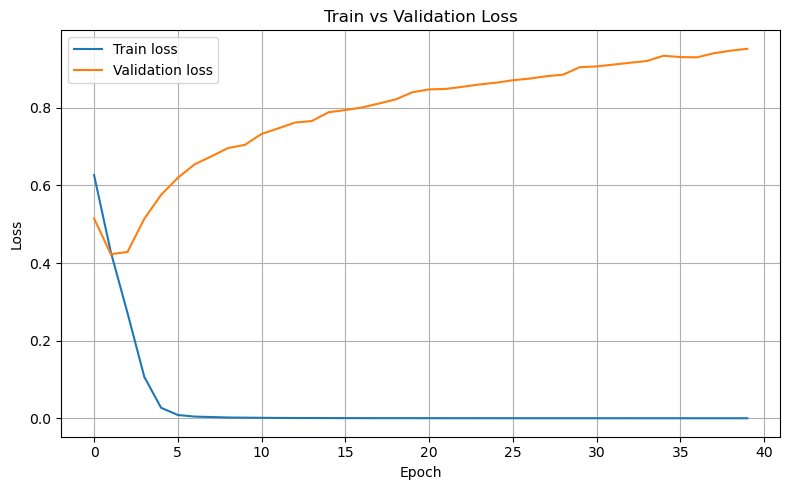

In [8]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Confusion Matrix and Metrics

Confusion matrix:
 [[621 242]
 [238 638]]

Classification report:
               precision    recall  f1-score   support

         0.0     0.7229    0.7196    0.7213       863
         1.0     0.7250    0.7283    0.7267       876

    accuracy                         0.7240      1739
   macro avg     0.7240    0.7239    0.7240      1739
weighted avg     0.7240    0.7240    0.7240      1739



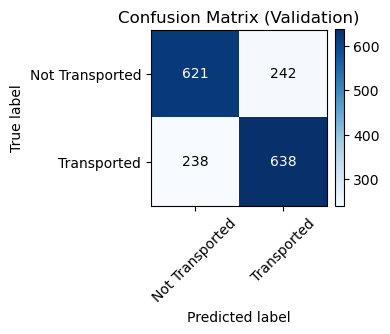

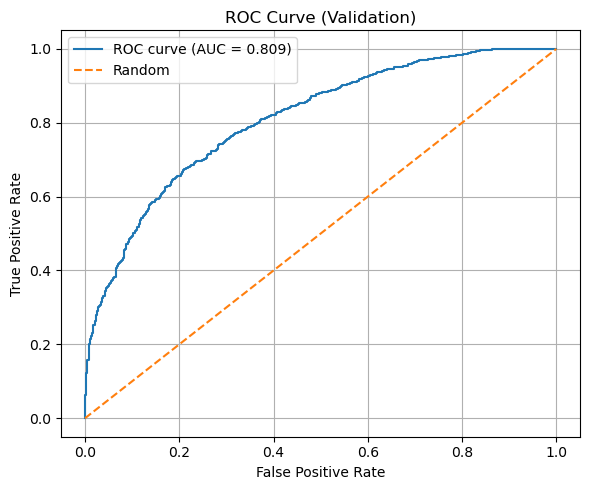

In [9]:
# get final validation predictions
val_loss, val_logits, val_targets = evaluate(model, val_loader, criterion, device)
val_probs = 1 / (1 + np.exp(-val_logits))  # sigmoid
val_preds = (val_probs >= 0.5).astype(int)

cm = confusion_matrix(val_targets, val_preds)
print("Confusion matrix:\n", cm)
print("\nClassification report:\n", classification_report(val_targets, val_preds, digits=4))

# plot confusion matrix
plt.figure(figsize=(4, 4))
im = plt.imshow(cm, interpolation="nearest", cmap="Blues")
plt.title("Confusion Matrix (Validation)")
plt.colorbar(im, fraction=0.046, pad=0.04)
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Not Transported", "Transported"], rotation=45)
plt.yticks(tick_marks, ["Not Transported", "Transported"])

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], "d"),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(val_targets, val_probs)
auc = roc_auc_score(val_targets, val_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Validation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Confusion matrix:
 [[3452    0]
 [   0 3502]]

Classification report:
               precision    recall  f1-score   support

         0.0     1.0000    1.0000    1.0000      3452
         1.0     1.0000    1.0000    1.0000      3502

    accuracy                         1.0000      6954
   macro avg     1.0000    1.0000    1.0000      6954
weighted avg     1.0000    1.0000    1.0000      6954



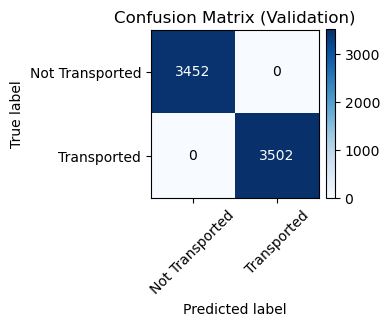

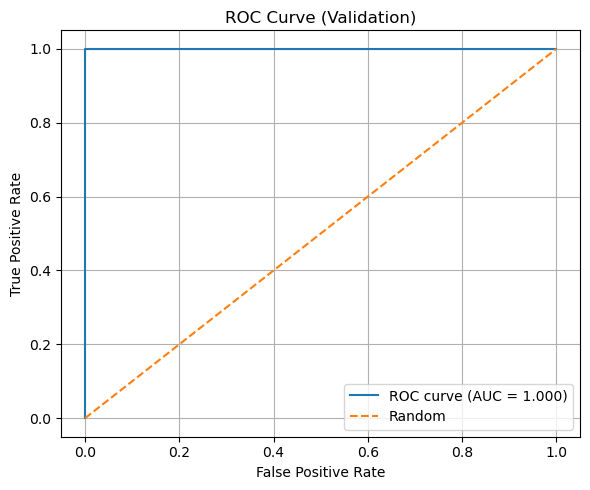

In [12]:
# get final validation predictions
val_loss, val_logits, val_targets = evaluate(model, train_loader, criterion, device)
val_probs = 1 / (1 + np.exp(-val_logits))  # sigmoid
val_preds = (val_probs >= 0.5).astype(int)

cm = confusion_matrix(val_targets, val_preds)
print("Confusion matrix:\n", cm)
print("\nClassification report:\n", classification_report(val_targets, val_preds, digits=4))

# plot confusion matrix
plt.figure(figsize=(4, 4))
im = plt.imshow(cm, interpolation="nearest", cmap="Blues")
plt.title("Confusion Matrix (Validation)")
plt.colorbar(im, fraction=0.046, pad=0.04)
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Not Transported", "Transported"], rotation=45)
plt.yticks(tick_marks, ["Not Transported", "Transported"])

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], "d"),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(val_targets, val_probs)
auc = roc_auc_score(val_targets, val_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Validation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Final Layer Embeddings Visualization

Embeddings shape: (8693, 64)


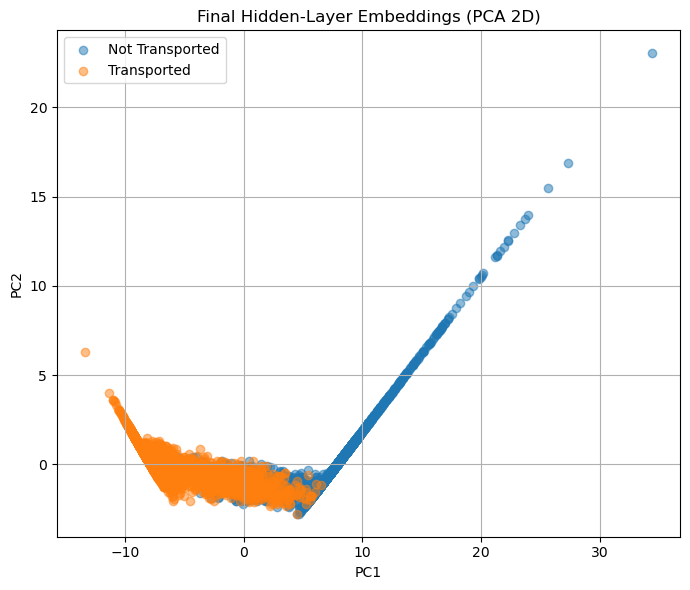

In [10]:
# create a DataLoader for the full training data to get embeddings
full_train_ds = TitanicDataset(X, y)
full_train_loader = DataLoader(full_train_ds, batch_size=512, shuffle=False)

model.eval()
all_embs = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in full_train_loader:
        X_batch = X_batch.to(device)
        _, feats = model(X_batch)
        all_embs.append(feats.cpu().numpy())
        all_labels.append(y_batch.numpy())

all_embs = np.vstack(all_embs)
all_labels = np.concatenate(all_labels)

print("Embeddings shape:", all_embs.shape)

# reduce to 2D with PCA for visualization
pca = PCA(n_components=2, random_state=42)
embs_2d = pca.fit_transform(all_embs)

plt.figure(figsize=(7, 6))
mask_transported = all_labels == 1
plt.scatter(embs_2d[~mask_transported, 0], embs_2d[~mask_transported, 1],
            alpha=0.5, label="Not Transported")
plt.scatter(embs_2d[mask_transported, 0], embs_2d[mask_transported, 1],
            alpha=0.5, label="Transported")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Final Hidden-Layer Embeddings (PCA 2D)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Save Embeddings to CSV

In [11]:
emb_dim = all_embs.shape[1]
emb_cols = [f"emb_{i}" for i in range(emb_dim)]

emb_df = pd.DataFrame(all_embs, columns=emb_cols)
emb_df[target_col] = all_labels.astype(int)

embeddings_path = "train_embeddings_simple_mlp.csv"
emb_df.to_csv(embeddings_path, index=False)

print("Saved embeddings to:", embeddings_path)
emb_df.head()


Saved embeddings to: train_embeddings_simple_mlp.csv


,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_55,emb_56,emb_57,emb_58,emb_59,emb_60,emb_61,emb_62,emb_63,Transported
0,2.577882,0.000000,0.000000,0.000000,1.949466,2.282358,0.000000,2.342462,1.758517,2.170787,...,2.170410,0.000000,2.175236,0.000000,0.000000,1.974480,0.000000,0.000000,0.000000,0
1,0.026714,1.472729,1.517141,1.610600,0.000000,0.016408,1.512651,0.145501,0.120237,0.076332,...,0.035172,1.623381,0.104534,1.493980,1.708037,0.014709,1.702976,1.884536,1.861361,1
2,4.140722,0.000000,0.000000,0.000000,3.160633,3.760946,0.000000,3.966371,2.940218,3.669074,...,3.506516,0.000000,3.478734,0.000000,0.000000,3.425041,0.000000,0.000000,0.000000,0
3,3.119910,0.000000,0.000000,0.000000,2.349967,2.864400,0.000000,3.010204,2.286183,2.784204,...,2.642804,0.000000,2.673733,0.000000,0.000000,2.549049,0.000000,0.000000,0.000000,0
4,0.149136,1.349409,1.394863,1.475008,0.060577,0.155063,1.358183,0.178255,0.168727,0.215735,...,0.112593,1.529836,0.167534,1.415818,1.573917,0.032344,1.493664,1.722945,1.715131,1
